In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

from myutil import *
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.impute import SimpleImputer

/Users/odahideto/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [19]:
def load_data(file_name_genba, file_name_goto):
    '''
    データをロードしてpj_noをキーとしてマージ。
    量的変数とカテゴリ変数に分けて返す
    '''
    genba = pd.read_table(file_name_genba)
    goto =  pd.read_table(file_name_goto)
    df = pd.merge(genba, goto, on='pj_no')   
        
    # TODO このブロックを関数化
    df_quantity = pd.DataFrame()
    df_categorical = pd.DataFrame()
    for col in df.columns:
        if df[col].dtypes == object:
            df_categorical[col] = df[col]
        else:
            df_quantity[col] = df[col]
    
    return df_quantity, df_categorical
    
train_quantity, train_categorical = load_data('../data/train_genba.tsv', '../data/train_goto.tsv')
test_quantity, test_categorical = load_data('../data/test_genba.tsv', '../data/test_goto.tsv')

train_src_Y = train_quantity.keiyaku_pr
train_quantity = train_quantity.drop('keiyaku_pr', axis=1)



'''
train_genba = pd.read_table('../data/train_genba.tsv')
train_goto =  pd.read_table('../data/train_goto.tsv')

train = pd.merge(train_genba, train_goto, on='pj_no')

print(train_genba.shape)
print(train_goto.shape)
print(train.shape)

train_src_X = train.drop('keiyaku_pr', axis=1)
train_src_Y = train.keiyaku_pr

test_genba = pd.read_table('../data/test_genba.tsv')
test_goto =  pd.read_table('../data/test_goto.tsv')

test_X = pd.merge(test_genba, test_goto, on='pj_no')
print('train_X shape', train_src_X.shape)
print('test_X shape', test_X.shape)

# light GBMのカテゴリ変数の扱い
#https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm

train_quantity = pd.DataFrame()
train_categorical = pd.DataFrame()

for col in train_src_X.columns:
    if train_src_X[col].dtypes == object:
        train_src_X[col] = train_src_X[col].astype('category')
        train_categorical[col] = train_src_X[col]
    else:
        train_quantity[col] = train_src_X[col]
        
for col in test_X.columns:
    if test_X[col].dtypes == object:
        test_X[col] = test_X[col].astype('category')

train_src_X.head()
'''

"\ntrain_genba = pd.read_table('../data/train_genba.tsv')\ntrain_goto =  pd.read_table('../data/train_goto.tsv')\n\ntrain = pd.merge(train_genba, train_goto, on='pj_no')\n\nprint(train_genba.shape)\nprint(train_goto.shape)\nprint(train.shape)\n\ntrain_src_X = train.drop('keiyaku_pr', axis=1)\ntrain_src_Y = train.keiyaku_pr\n\ntest_genba = pd.read_table('../data/test_genba.tsv')\ntest_goto =  pd.read_table('../data/test_goto.tsv')\n\ntest_X = pd.merge(test_genba, test_goto, on='pj_no')\nprint('train_X shape', train_src_X.shape)\nprint('test_X shape', test_X.shape)\n\n# light GBMのカテゴリ変数の扱い\n#https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm\n\ntrain_quantity = pd.DataFrame()\ntrain_categorical = pd.DataFrame()\n\nfor col in train_src_X.columns:\n    if train_src_X[col].dtypes == object:\n        train_src_X[col] = train_src_X[col].astype('category')\n        train_categorical[col] = train_src_X[col]\n    else:\n        train_quantity[col] = train_src_X[col]\n        

In [20]:
train_quantity.describe()

,pj_no,chiseki_js_hb,chiseki_kb_hb,kempei1,kempei2,yoseki1,yoseki2,tateuri_su,tochiuri_su,joken_su,hy1f_date_su,hy2f_date_su,hy3f_date_su,road1_fi,road1_mg,road2_fi,road2_mg,road3_fi,road3_mg,road4_fi,road4_mg,kaoku_hb,yheki_kotei,gk_sho_kyori,gk_chu_kyori,minmenseki,rosenka_hb,koji_hb,kijun_hb,mseki_yt_hb,mseki_rd_hb,mseki_dp_hb,tc_mseki_min_hb,tc_mseki_max_hb,tt_mseki_min_hb,tt_mseki_max_hb,tc_mseki_avg_hb,tt_mseki_avg_hb,fi4m_kyori,fi3m_kyori,bus_hon,gk_yoc_tm,gk_sho_tm,gk_chu_tm,eki_kyori1,teiho1,eki_kyori2,teiho2,tc_mseki,tt_mseki,fukuin,magutchi,niwasaki,garage
count,6461.000000,6461.000000,6456.000000,6461.000000,5917.000000,6461.000000,5917.000000,6460.000000,6218.000000,6234.000000,6212.0,6458.000000,6274.000000,6461.000000,6461.000000,6210.000000,6210.000000,5965.000000,5965.000000,5920.000000,5920.000000,6268.000000,6461.00000,6461.000000,6461.000000,3679.000000,6461.000000,6461.000000,6.461000e+03,6461.000000,6432.000000,6430.000000,6461.000000,6461.000000,6461.000000,6461.000000,6461.000000,6460.000000,6131.000000,6102.000000,2956.000000,6461.000000,6461.000000,6461.000000,6461.000000,1391.000000,192.000000,90.000000,6461.000000,6461.000000,6367.000000,6367.000000,6461.000000,6461.000000
mean,1384.093794,736.291579,777.740861,57.785173,5.098868,165.551772,15.453777,4.539319,0.350917,0.048604,0.0,4.495819,0.097864,5.693631,20.442236,2.874895,12.959824,0.817205,5.065866,0.146098,1.429172,43.709947,0.38160,811.431512,1185.906826,68.518891,83047.520817,120167.063922,1.196350e+05,692.476624,55.936087,3.101868,134.538856,180.801856,96.516463,101.666443,145.048291,100.244232,1.742910,0.177042,29.764547,11.811175,10.461074,15.106176,15.258010,4.773544,12.697917,3.622222,140.288349,96.303482,5.557022,8.829752,3.841002,1.786411
std,806.583481,807.762451,873.449310,4.895278,16.620629,51.551108,51.675946,4.651619,1.672873,0.483694,0.0,4.778028,0.547433,3.007846,14.185390,4.143426,17.373378,2.338422,15.978411,0.907150,9.173202,155.951922,0.47153,504.475093,650.204398,72.182357,45109.023976,51723.169158,6.126838e+04,737.567502,138.147303,24.062456,48.339130,2602.782793,19.993146,13.861124,65.144367,14.831647,17.212068,3.066584,62.591329,7.580993,6.294150,8.140534,7.129941,3.031924,6.632649,1.632381,50.865584,24.355454,2.260369,4.548319,12.315084,0.747053
min,0.000000,39.160000,39.160000,40.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.000000,10.000000,0.000000,0.000000,12000.000000,0.000000e+00,39.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.160000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,28.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,681.000000,216.510000,219.270000,60.000000,0.000000,100.000000,0.000000,2.000000,0.000000,0.000000,0.0,1.000000,0.000000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10000,480.000000,700.000000,0.000000,60000.000000,88200.000000,8.530000e+04,215.300000,0.000000,0.000000,105.320000,115.820000,95.220000,98.010000,112.550000,96.460000,0.000000,0.000000,0.000000,7.000000,6.000000,9.000000,10.000000,3.000000,5.000000,3.000000,110.080000,96.380000,4.000000,6.200000,2.000000,1.000000
50%,1376.000000,441.790000,457.125000,60.000000,0.000000,200.000000,0.000000,3.000000,0.000000,0.000000,0.0,3.000000,0.000000,5.000000,16.800000,1.900000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.30000,720.000000,1100.000000,100.000000,85500.000000,114000.000000,1.150000e+05,435.610000,0.000000,0.000000,122.210000,136.000000,100.000000,104.490000,132.000000,102.460000,0.000000,0.000000,10.000000,10.000000,9.000000,14.000000,14.000000,4.000000,13.500000,3.000000,129.000000,102.260000,5.000000,8.500000,3.000000,2.000000
75%,2101.000000,919.520000,949.670000,60.000000,0.000000,200.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,0.000000,6.000000,25.10000

In [21]:
train_quantity.isnull().sum()

pj_no                 0
chiseki_js_hb         0
chiseki_kb_hb         5
kempei1               0
kempei2             544
yoseki1               0
yoseki2             544
tateuri_su            1
tochiuri_su         243
joken_su            227
hy1f_date_su        249
hy2f_date_su          3
hy3f_date_su        187
road1_fi              0
road1_mg              0
road2_fi            251
road2_mg            251
road3_fi            496
road3_mg            496
road4_fi            541
road4_mg            541
kaoku_hb            193
yheki_kotei           0
gk_sho_kyori          0
gk_chu_kyori          0
minmenseki         2782
rosenka_hb            0
koji_hb               0
kijun_hb              0
mseki_yt_hb           0
mseki_rd_hb          29
mseki_dp_hb          31
tc_mseki_min_hb       0
tc_mseki_max_hb       0
tt_mseki_min_hb       0
tt_mseki_max_hb       0
tc_mseki_avg_hb       0
tt_mseki_avg_hb       1
fi4m_kyori          330
fi3m_kyori          359
bus_hon            3505
gk_yoc_tm       

In [22]:
train_categorical.isnull().sum()

jukyo                0
yoto1                0
yoto2             5949
josui                0
gesui                0
gas                  0
usui                 0
road1_hk             0
road1_sb             0
road2_hk          3215
road2_sb          3215
road3_hk          5574
road3_sb          5574
road4_hk          6290
road4_sb          6290
kaoku_um             0
yheki_umu            0
yheki_yohi           0
kborjs               0
hw_status            0
toshikuiki1          0
toshikuiki2       6394
kodochiku            0
chikukeikaku         0
keikakuroad          0
kaihatsukyoka        0
t53kyoka             0
hokakyoka            0
bokachiiki           0
hokakisei1        4681
hokakisei2        5611
hokakisei3        6275
hokakisei4        6425
kinshijiko           0
fi4m_yohi            0
fi3m_yohi            0
bus_yohi             0
sho_conv          3623
sho_super         4855
sho_shoten        6297
sho_market        6261
shu_jutaku         755
shu_park          6242
shu_shop   

In [23]:
# カテゴリ変数の欠損値を埋めて結合
train_categorical = train_categorical.fillna('Empty')
train_src_X = pd.concat([train_quantity, train_categorical], axis = 1)

test_categorical = test_categorical.fillna('Empty')
test_X = pd.concat([test_quantity, test_categorical], axis = 1)

In [24]:
train_categorical.describe()

,jukyo,yoto1,yoto2,josui,gesui,gas,usui,road1_hk,road1_sb,road2_hk,road2_sb,road3_hk,road3_sb,road4_hk,road4_sb,kaoku_um,yheki_umu,yheki_yohi,kborjs,hw_status,toshikuiki1,toshikuiki2,kodochiku,chikukeikaku,keikakuroad,kaihatsukyoka,t53kyoka,hokakyoka,bokachiiki,hokakisei1,hokakisei2,hokakisei3,hokakisei4,kinshijiko,fi4m_yohi,fi3m_yohi,bus_yohi,sho_conv,sho_super,sho_shoten,sho_market,shu_jutaku,shu_park,shu_shop,shu_factory,shu_hvline,shu_tower,shu_bochi,shu_sogi,shu_zoki,shu_kokyo,shu_highway,shu_kaido,shu_line_ari,shu_line_nashi,shu_soon,rs_e_kdate2,rs_e_kdate3,rs_e_parking,rs_e_zoki,rs_e_m_ari,rs_e_m_nashi,rs_e_tahata,rs_w_kdate2,rs_w_kdate3,rs_w_parking,rs_w_zoki,rs_w_m_ari,rs_w_m_nashi,rs_w_tahata,rs_s_kdate2,rs_s_kdate3,rs_s_parking,rs_s_zoki,rs_s_m_ari,rs_s_m_nashi,rs_s_tahata,rs_n_kdate2,rs_n_kdate3,rs_n_parking,rs_n_zoki,rs_n_m_ari,rs_n_m_nashi,rs_n_tahata,rosen_nm1,eki_nm1,bas_toho1,bastei_nm1,rosen_nm2,eki_nm2,bas_toho2,bastei_nm2,id,levelplan,road_st,setsudo_hi,setsudo_kj,jigata,hiatari,kobetsu1,kobetsu2,kobetsu3,kobetsu4
count,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461,6461
unique,1234,12,10,2,2,3,3,9,3,9,4,9,4,8,3,2,2,2,3,7,4,4,6,2,2,2,2,2,6,21,20,8,4,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,27,204,3,96,17,57,4,36,6461,28,5,56,4,5,4,26,26,25,17
top,埼玉県川越市大字寺尾,第一種低層住居専用地域,Empty,公営,公共下水,都市ガス,宅内処理,東,公道,Empty,Empty,Empty,Empty,Empty,Empty,（無）,（無）,（不要）,実測,更地,市街化区域,Empty,指定無,（無）,（無）,（不要）,（不要）,（不要）,防火指定無,Empty,Empty,Empty,Empty,（無）,（不要）,（不要）,（不要）,Empty,Empty,Empty,Empty,○,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,Empty,○,Empty,Empty,Empty,Empty,Empty,Empty,○,Empty,Empty,Empty,Empty,Empty,Empty,○,Empty,Empty,Empty,Empty,Empty,Empty,○,Empty,Empty,Empty,Empty,Empty,Empty,東武東上線,八潮,徒歩,Empty,Empty,Empty,Empty,Empty,train_2530,2F/4LDK,問題なし,南,良い,整形地,良い,Empty,Empty,Empty,Empty
freq,53,2186,5949,6416,5639,4585,6027,1311,5907,3215,3215,5574,5574,6290,6290,5058,6151,5968,3317,3739,5921,6394,5837,5616,6228,4777,6275,5398,3631,4681,5611,6275,6425,6353,6293,6418,4856,3623,4855,6297,6261,5706,6242,6392,6322,6394,6436,6419,6458,6375,6410,6436,6288,6374,6373,6413,3730,6377,6166,6385,6402,6307,6092,3833,6402,6203,6411,6428,6320,6119,3630,6336,6209,6361,6408,6320,6190,3609,6385,6130,6403,6438,6322,6079,879,203,5002,6147,6269,6269,5875,6371,1,5003,6054,1399,3467,4837,3470,3814,6028,6195,6412


### 欠損値修正

In [25]:
def impute_bus_hon(df):
    buss =[]
    for bus in df.bus_hon:
        if (np.isnan(bus)):
            buss.append(0)
        else:
            buss.append(bus)

    df.bus_hon = buss        
    return df

train_src_X = impute_bus_hon(train_src_X)
test_X = impute_bus_hon(test_X)

### 特徴量追加

In [26]:
# cityを追加
import re

train_src_X['jukyo'].value_counts()
pattern = r'(^.+?[市区郡])'
repatter = re.compile(pattern)

cities_train = []
for city in train_src_X.jukyo:
    city = city.replace('埼玉県', '')
    city = city.replace('さいたま市', '')
    result = repatter.match(city)
    if result != None:
        cities_train.append(result.group())
    else:
        print(city)
        cities_train.append(city)

train_src_X['city'] = cities_train
train_src_X['city'] = train_src_X['city'].astype('category')

cities_test = []
for city in test_X.jukyo:
    city = city.replace('埼玉県', '')
    city = city.replace('さいたま市', '')
    result = repatter.match(city)
    if result != None:
        cities_test.append(result.group())
    else:
        cities_test.append(city)

test_X['city'] = cities_test
test_X['city'] = test_X['city'].astype('category')

train_src_X.city.value_counts()

compare_columns(train_src_X, test_X)

にっさい花みず木
西鶴ヶ岡
西鶴ヶ岡
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
宮代町宮代台
大字下日出谷
杉戸町清地
松伏町田中
大字大谷口
大字大谷口
大字大谷口
大字水野字逃水
大字水野字逃水
大字南中丸
大字南中丸


True

### 特徴量選択

In [31]:
# カテゴリ変数に変換

# TODO 関数化
def convert_object_category(df):
    for col in df.columns:
        if df[col].dtypes == object:
            df[col] = df[col].astype('category')
    return df

train_src_category_X = convert_object_category(train_src_X)
test_src_category_X = convert_object_category(test_X)

/Users/odahideto/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's mape: 0.0882558
[1000]	valid_0's mape: 0.0885313
[1500]	valid_0's mape: 0.0887645
Early stopping, best iteration is:
[628]	valid_0's mape: 0.0881388


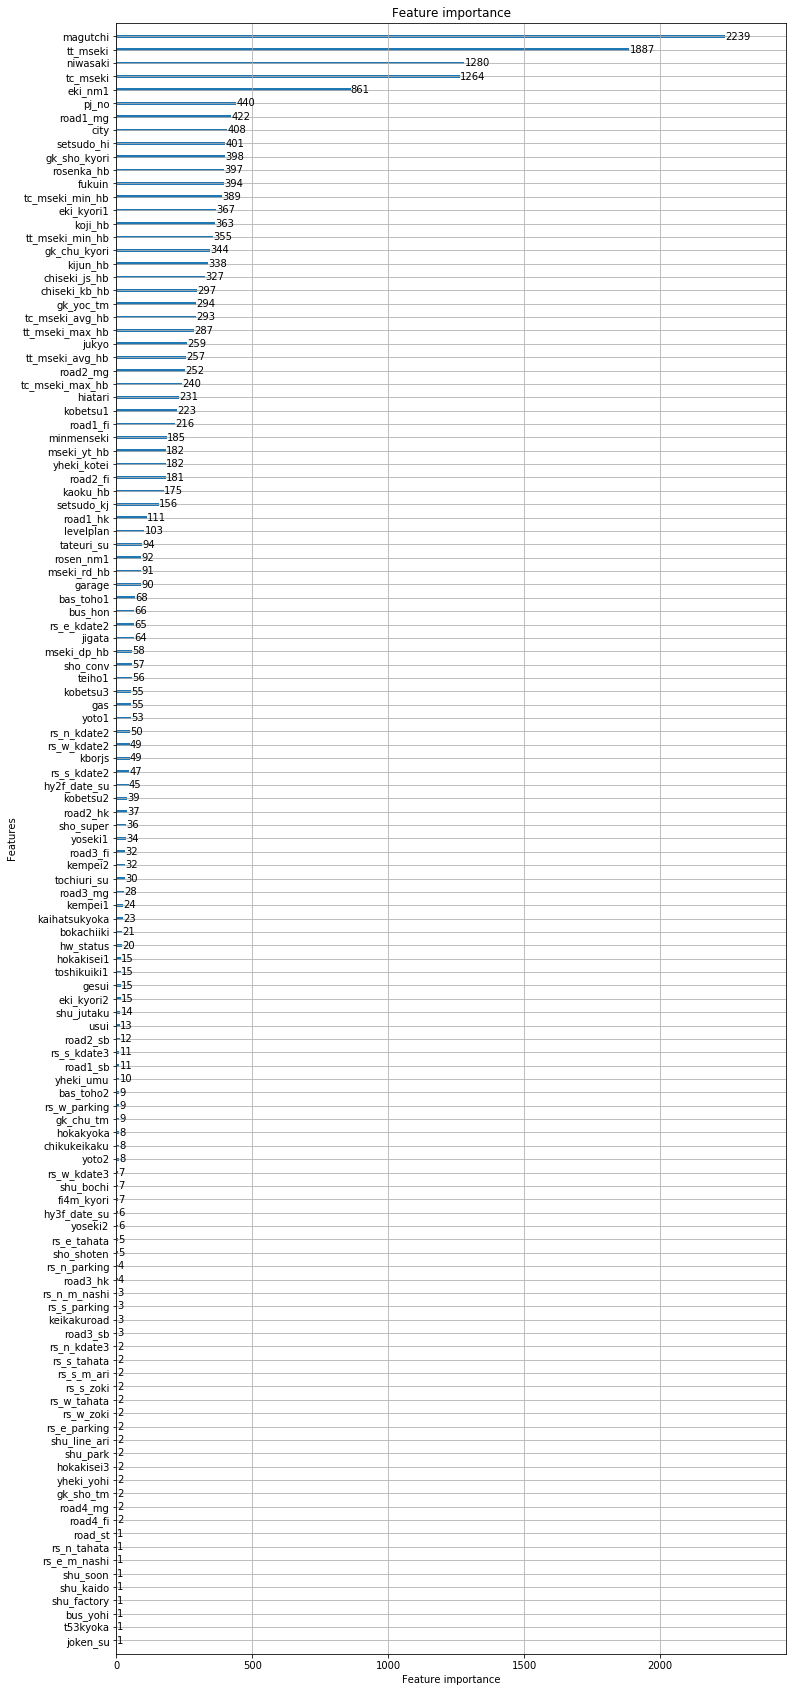

In [32]:
# データセットを生成する
X_train, X_eval, y_train, y_eval = train_test_split(train_src_category_X, train_src_Y,train_size=0.8)

# LightGBM のハイパーパラメータ
lgbm_params = {
    'objective': 'regression',
    'metric': 'mape',
}

# 上記のパラメータでモデルを学習する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=10000, verbose_eval=500, early_stopping_rounds=1000)

lgb.plot_importance(model, figsize=(12, 30))
plt.show()

In [34]:
model.feature_importance()

array([ 440,  327,  297,   24,   32,   34,    6,   94,   30,    1,    0,
         45,    6,  216,  422,  181,  252,   32,   28,    2,    2,  175,
        182,  398,  344,  185,  397,  363,  338,  182,   91,   58,  389,
        240,  355,  287,  293,  257,    7,    0,   66,  294,    2,    9,
        367,   56,   15,    0, 1264, 1887,  394, 2239, 1280,   90,  259,
         53,    8,    0,   15,   55,   13,  111,   11,   37,   12,    4,
          3,    0,    0,    0,   10,    2,   49,   20,   15,    0,    0,
          8,    3,   23,    1,    8,   21,   15,    0,    2,    0,    0,
          0,    0,    1,   57,   36,    5,    0,   14,    2,    0,    1,
          0,    0,    7,    0,    0,    0,    0,    1,    2,    0,    1,
         65,    0,    2,    0,    0,    1,    5,   49,    7,    9,    2,
          0,    0,    2,   47,   11,    3,    2,    2,    0,    2,   50,
          2,    4,    0,    0,    3,    1,   92,  861,   68,    0,    0,
          0,    9,    0,    0,  103,    1,  401,  1

/Users/odahideto/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's mape: 0.0882558
[1000]	valid_0's mape: 0.0887834
[1500]	valid_0's mape: 0.0889305
Early stopping, best iteration is:
[628]	valid_0's mape: 0.0881388


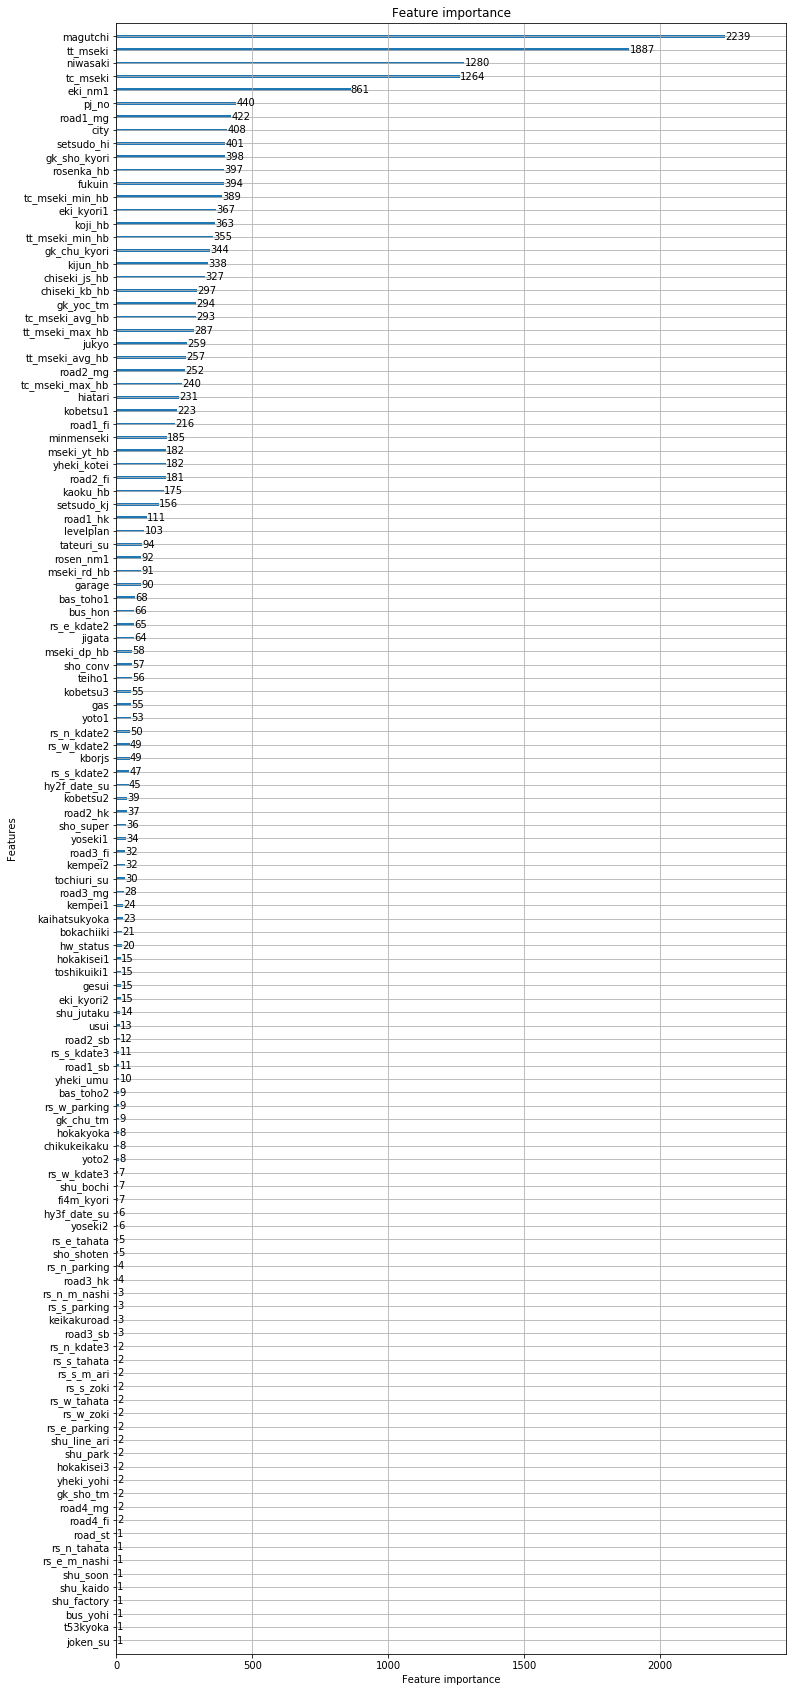

In [35]:
selected_X_src_train = pd.DataFrame()
selected_X_train = pd.DataFrame()
selected_X_test = pd.DataFrame()
selected_X_eval   = pd.DataFrame()
for importance, col in zip(model.feature_importance(), X_train.columns):
    if importance > 0:
        selected_X_src_train[col] = train_src_category_X[col]
        selected_X_test[col] = test_src_category_X[col]
        selected_X_train[col] = X_train[col]
        selected_X_eval[col] = X_eval[col]

lgb_train_selected = lgb.Dataset(selected_X_train, y_train)
lgb_eval_selected = lgb.Dataset(selected_X_eval, y_eval, reference=lgb_train_selected)
model_selected = lgb.train(lgbm_params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=500, early_stopping_rounds=1000)

lgb.plot_importance(model_selected, figsize=(12, 30))
plt.show()

### パラメータチューニング

In [36]:
import optuna
from sklearn.model_selection import KFold

NFOLDS = 7
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=218)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def opt(trial):
    '''
    drop_rate = trial.suggest_uniform('drop_rate', 0, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.8, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 5, 1000)
    verbosity = trial.suggest_int('verbosity', -1, 1)

    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100000)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 500)
 
    # http://kamonohashiperry.com/archives/209
    params = {
              　'objective': 'regression',
              　'metric': 'mape',
              　"boosting_type": "gbdt",
                "learning_rate": 0.1,
                "max_depth": trial.suggest_int('min_data_in_leaf', 3, 10),
                "min_child_weight": trial.suggest_int('min_child_weight', 0, 15),
              
            　　"num_leaves": num_leaves,
             　 "max_bin": 256,
              　"feature_fraction": feature_fraction,
              　"verbosity": verbosity,
              　"drop_rate": drop_rate,
              　"is_unbalance": False,
              　"max_drop": 50,
              　"min_child_samples": min_child_samples,
              　"min_split_gain": 0,
              　"min_data_in_leaf": min_data_in_leaf,
              　"subsample": subsample
              }
    '''
    params = {
            'objective': 'regression',
            'metric': 'mape',
            "boosting_type": "gbdt",    
            "learning_rate": 0.1,
            # L2 正則化
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e3),
            # L1 正則化
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e3),
            # 弱学習木ごとに使う特徴量の割合
            # 0.5 だと全体のうち半分の特徴量を最初に選んで, その範囲内で木を成長させる
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, .1),
            # 学習データ全体のうち使用する割合
            # colsample とは反対に row 方向にサンプルする
            'subsample': trial.suggest_discrete_uniform('subsample', .5, 0.9, .1),
            # 木の最大の深さ
            # たとえば 5 の時各弱学習木の各データに対するルールは、最大でも5に制限される.
            'max_depth': trial.suggest_categorical('max_depth', [3, 5, 6, 7, 8]),
            # 末端ノードに含まれる最小のサンプル数
            # これを下回るような分割は作れなくなるため, 大きく設定するとより全体の傾向でしか分割ができなくなる
            # [NOTE]: 数であるのでデータセットの大きさ依存であることに注意
        }

    
    
    # train
    #model = lgb.train(params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=1000)
    #y_pred = model.predict(selected_X_eval, num_iteration=model.best_iteration)
    #return mean_absolute_percentage_error(y_eval, y_pred)

    '''
    X = selected_X_src_train
    y = train_src_Y
    
    
    train_all = lgb.Dataset(X, y)
    
    model = lgb.train(params, lgb_train_selected, num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=1000)
    y_pred = model.predict(selected_X_eval, num_iteration=model.best_iteration)
    return mean_absolute_percentage_error(y_eval, y_pred)
    '''
    
    
    # cross validation

    #https://qiita.com/Tawasshy/items/699d8927860de6b37fe4
    X = selected_X_src_train
    y = train_src_Y

    x_score = []
    final_cv_train = np.zeros(len(y))
    final_cv_pred = np.zeros(int(len(y) / NFOLDS))

    cv_train = np.zeros(len(y))
    cv_pred = np.zeros(int(len(y) / NFOLDS))

    params['seed'] = 0

    kf = kfold.split(X, y)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate, label_train, label_validate = X.loc[train_fold], X.loc[validate], y[train_fold], y[validate]

        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params, dtrain, valid_sets=dvalid,  num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=100)
        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_validate, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)

    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred
   
    
    return mean_absolute_percentage_error(y, cv_train)

    
optuna.logging.disable_default_handler()
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
study.optimize(opt, n_trials=10)

print('best_params')
print(study.best_params)
print('best_value')
print(study.best_value)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[608]	valid_0's mape: 0.0814913
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[660]	valid_0's mape: 0.0660796
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[677]	valid_0's mape: 0.0711466
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[855]	valid_0's mape: 0.0812914
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[388]	valid_0's mape: 0.0731225
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[539]	valid_0's mape: 0.0724478
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[400]	valid_0's mape: 0.0814763
Training until validation scores don't improve for 100 rounds.
Early stopping, best iterat

In [37]:
params = {
        'objective': 'regression',
        'metric': 'mape',
        "boosting_type": "gbdt",    
        "learning_rate": 0.1,
}
params.update(study.best_params)
model = lgb.train(params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[563]	valid_0's mape: 0.0880658


In [38]:
model.predict(selected_X_eval, num_iteration=model.best_iteration)

array([25615751.21962166, 23941647.44994307, 26787251.96596456, ...,
       24800054.53792691, 27949550.60974894, 36651212.34813157])

### 予測

In [39]:
ypred = model.predict(selected_X_test, num_iteration=model.best_iteration)
result = pd.DataFrame(columns=['id', 'pred'])
result['id'] = test_X['id']
result['pred'] = ypred
result.to_csv('result.tsv', index=False, header=False, sep='\t')